# 各種インポート

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q timm
!pip install -q torchmetrics

     |████████████████████████████████| 512 kB 8.0 MB/s 
     |████████████████████████████████| 419 kB 9.1 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms as T
import timm
from torchmetrics import F1Score
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# データの読み込み

In [ ]:
images = np.load('/content/drive/MyDrive/Competition/ProbSpace/日本画/data/train_data.npz')
print(images.files)

['arr_0', 'arr_1']


In [ ]:
print(images['arr_0'].shape)
print(images['arr_1'].shape)

(6446, 256, 256, 3)
(6446,)


In [ ]:
train_images = images['arr_0']
train_labels = images['arr_1']

In [ ]:
train_images = train_images.transpose((0,3,1,2))

In [ ]:
# 貴族、武士、化け物、平民
classes = {0: 'noble', 1: 'warrior', 2: 'incarnetion', 3: 'commoner'}

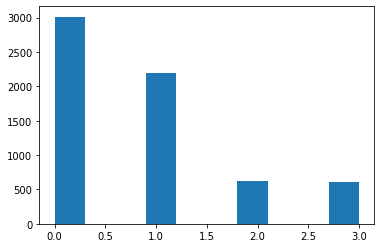

In [ ]:
plt.figure()
plt.hist(train_labels)
plt.show()

In [ ]:
# test data
test_images = np.load('/content/drive/MyDrive/Competition/ProbSpace/日本画/data/test_data.npz')['arr_0']
test_images = test_images.transpose((0,3,1,2))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_images).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, pin_memory=True)

# モデルの読み込み

In [ ]:
class My_Dataset(Dataset):

  def __init__(self, images, labels, transform=None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.transform = transform

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

  def __len__(self):
    return len(self.labels)


def train_transformer(n=1, m=1):
  return T.Compose([T.RandAugment(num_ops=n, magnitude=m)])

def valid_transformer():
  return T.Compose([T.ToTensor()])

In [ ]:
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)
"""
for fold, (train_index, valid_index) in enumerate(kf.split(train_images, train_labels)):
  valid_dataset = My_Dataset(torch.from_numpy(train_images[valid_index]).float(), torch.from_numpy(train_labels[valid_index].astype(np.int64)))
  valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
  if fold == 0:
    break
"""

In [ ]:
#valid_dataset.labels

tensor([0, 0, 0,  ..., 0, 2, 1])

In [ ]:
#len(valid_dataset.labels)

1290

In [ ]:
#model_name = 'resnet34'
model_name = 'efficientnet_b3'
num_classes = 4
# 学習済みモデル
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/fold*')
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/eff_b3_fold*')
weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/eff_b3_FocalLoss_RandAug_fold*')
#weights = glob.glob('/content/drive/MyDrive/Competition/ProbSpace/日本画/checkpoints/eff_b3_FocalLoss_fold1')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 推論

In [ ]:
def softmax(a):
    c = np.max(a) # 最大値
    exp_a = np.exp(a - c) # 分子:オーバーフロー対策
    sum_exp_a = np.sum(exp_a) # 分母
    y = exp_a / sum_exp_a 
    return y

In [ ]:
#all_predicts = np.zeros((len(valid_dataset.labels), 4))
all_predicts = np.zeros((len(test_images), 4))
with torch.no_grad():
  for w in weights:
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(w))
    mode = model.to(device)
    model.eval()
    predicts = []
    for x in test_loader:
      x = x[0].to(device)
      outputs = model(x)
      
      #x = x[0].to(device)
      #outputs = model(x)
      #preds = torch.max(outputs, dim=1)[1]
      tmp = outputs.cpu().numpy()
      #print(outputs.cpu().numpy().shape)
      #print(tmp)
      
      # softmax
      for i, l in enumerate(tmp):
        #print(l)
        #print(i)
        #print(tmp[i])
        tmp[i] = softmax(tmp[i])
        #print(tmp[i])

      predicts.append(tmp)

    all_predicts += np.concatenate(predicts)

In [ ]:
all_predicts

array([[2.91300861e-03, 4.96791577e+00, 9.38550476e-03, 1.97858722e-02],
       [2.07917332e+00, 2.85945222e+00, 3.13923378e-02, 2.99822623e-02],
       [4.97513217e+00, 4.86053458e-03, 1.22249824e-02, 7.78214674e-03],
       ...,
       [3.55030796e-04, 8.11612907e-04, 4.99638480e+00, 2.44850703e-03],
       [2.02064410e-02, 4.91885704e+00, 2.24124906e-02, 3.85239949e-02],
       [5.74550453e-04, 4.99257421e+00, 3.32332151e-03, 3.52812975e-03]])

In [ ]:
np.sum(all_predicts,axis=-1)

array([5.00000016, 5.00000015, 4.99999983, ..., 4.99999995, 4.99999996,
       5.00000022])

# 擬似ラベルの作成

In [ ]:
# 疑似ラベル
psuedo_labels=[]
psuedo_images=[]

for i, l in enumerate(all_predicts):
  if all_predicts[i].max() >= 4.5:  # 4.5以上なら1
    psuedo_labels.append(np.argmax(all_predicts[i]))

    psuedo_images.append(test_images[i])
  #print(all_predicts[i].max())

print(len(psuedo_labels))
print(len(psuedo_images))

1460
1460


In [ ]:
np.array(psuedo_images).transpose((0,2,3,1)).shape

(1460, 256, 256, 3)

In [ ]:
psuedo_images = np.array(psuedo_images).transpose((0,2,3,1))

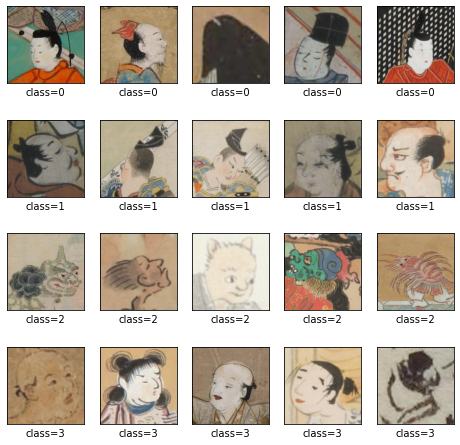

In [ ]:
# 各クラスの画像を表示してみる
images = [[] for _ in range(4)]

for image, label in zip(psuedo_images, psuedo_labels):
  images[label].append(image)

figure = plt.figure(figsize=(8, 8))

for i in range(4):
  for j, img in enumerate(images[i][15:20]):
    axis = figure.add_subplot(4, 5, i * 5 + j + 1)

    axis.imshow(img)
    axis.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    axis.set_xlabel(f'class={i}')

plt.show()

In [ ]:
key, cnt = np.unique(psuedo_labels, return_counts = True)
for k,c in zip(key,cnt):
    print(k,c)

0 767
1 494
2 130
3 69


In [ ]:
np.savez("/content/drive/MyDrive/Competition/ProbSpace/日本画/data/psuedo_label", psuedo_images, psuedo_labels)

In [ ]:
np.load("/content/drive/MyDrive/Competition/ProbSpace/日本画/data/psuedo_label.npz")["arr_1"]

array([1, 0, 1, ..., 2, 1, 1])

In [ ]:
np.save("psuedo_images.npz", psuedo_images)
np.save("psuedo_labels.npz", psuedo_labels)